In [1]:
import warnings
warnings.filterwarnings('ignore')

# <span style="color:Maroon">Case Study: Usage of Data Science in Entertainment Industry.

#### <span style="color:Green">Select optimal advetisement to display in break time for a TV Show, based on what was recently shown in the TV

## <span style="color:Maroon">Gradient Boosting Classifier

<span style="color:Green">Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.(source: Wikipedia). Hyper-parameters to be tuned in Gradient Boosting model are:
    
<span style="color:Green">$\;\;\;\;\;\;$1. n_estimators: number of trees in the foreset
    
<span style="color:Green">$\;\;\;\;\;\;$2. learning_rate: This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates
    
<span style="color:Green">$\;\;\;\;\;\;$3. subsample: The fraction of observations to be selected for each tree. Selection is done by random sampling
    
<span style="color:Green">$\;\;\;\;\;\;$4. loss: It refers to the loss function to be minimized in each split.
    
<span style="color:Green">$\;\;\;\;\;\;$5. max_features: max number of features considered for splitting a node
    
<span style="color:Green">$\;\;\;\;\;\;$6. max_depth: max number of levels in each decision tree
    
<span style="color:Green">$\;\;\;\;\;\;$7. min_samples_split: min number of data points placed in a node before the node is split
    
<span style="color:Green">$\;\;\;\;\;\;$8. min_samples_leaf: min number of data points allowed in a leaf node

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import os as os
np.random.seed(0)
pd.option_context('display.max_rows', None, 'display.max_columns', None)

In [3]:
# Setting the working directory to the folder
direc = os.getcwd()
os.chdir("..//Data//")

In [4]:
# Read the data in pandas dataframe
data = pd.read_csv("Dataset.csv")
data = data.fillna(0)

In [5]:
# Dependent variable (is given name of target)
target = 'h_food_str'
# Other dependent variables (These should be dropped from our dataset)
dv_list = ['h_alcohol_str', 'h_hot_drink_str', 'h_phone_str']
# drop the dv_list from the data (as In future, these labels won't be available to us (dv_list).
# Hence, for our modeling purpose, these variables are being dropped from the data.)
data = data.drop(dv_list, axis=1)

In [6]:
# One hot encoding of 'show_name' variable
df1 = pd.get_dummies(data['show_name'], prefix = 'show_name')
data = data.join(df1)
data.head()

,show_name,time_offset,r_abies,r_abyssinian,r_accessories,r_accipiter,r_acorn,r_adapter,r_adorable,r_adventure,...,r_zoo,h_food_str,show_name_fresh_meat,show_name_friday_night_dinner,show_name_hollyoaks,show_name_made_in_chelsea,show_name_made_in_chelsea_la,show_name_my_mad_fat_diary,show_name_peep_show,show_name_the_inbetweeners
0,fresh_meat,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,fresh_meat,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
2,fresh_meat,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
3,fresh_meat,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
4,fresh_meat,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0


### <span style="color:Maroon">Train-Test Split
<span style="color:Green">Divide the data in 70:30 ratio for training the model and validating the model

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop([target],axis=1), data[target], test_size=0.30, 
                                                    random_state=12345)

In [9]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [10]:
# Check if the random samples have similar mean
print (f"Train Dependent variable: {np.round(np.mean(y_train)*100,2)}")
print (f"Test Dependent variable: {np.round(np.mean(y_test)*100,2)}")

Train Dependent variable: 8.83
Test Dependent variable: 8.85


<span style="color:Blue">__Comments:__ The means of dependent variable are very similar in test and train dataset

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### <span style="color:Maroon">Gradient Boosting Classifier

In [12]:
# Import required libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt

In [13]:
# Actual data with one hot encoding for show_name
data_gbm = data.drop(["show_name","time_offset"], axis=1)

###### <span style="color:Maroon">Variable Reduction using GBM:
<span style="color:Green">To select the top N variables, we will use the GBM Variable Importance metrics to reduce the variables. The process for the same is:
    
<span style="color:Green">$\;\;\;\;\;\;$1. Build a GBM model with all variables and Number of trees = 100
    
<span style="color:Green">$\;\;\;\;\;\;$2. Calculate variable importance for all the variables
    
<span style="color:Green">$\;\;\;\;\;\;$3. Drop all the variables with Cumualtive Variable Importance < 0.98 (lowest important variables)
                                                                                              
<span style="color:Green">$\;\;\;\;\;\;$4. Repeat the steps 1 to 3, till GBM can no longer drop any variable based on variable Importance
        
<span style="color:Green">For more details on "variable importance metrics" for GBM, please refer the below link: https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting

In [14]:
# Variable reduction using GBM
def varred_gbm(X, y, independent_vars):
    X_reduce = X[independent_vars]
    # Number of trees = 10 x number of variables
    ntrees = 100
    clf = GradientBoostingClassifier(learning_rate=0.05,n_estimators=ntrees, max_depth=4, min_samples_split=0.05, 
                                     max_features='sqrt', subsample=0.7, random_state=12345)
    clf.fit(X_reduce,y)
    VarSel = pd.DataFrame(independent_vars)
    VarSel.columns = ["Variables"]
    VarSel["Importance"] = (clf.feature_importances_)
    VarSel = VarSel.sort_values("Importance", ascending=False)
    VarSel["Cum_Imp"] = VarSel["Importance"].cumsum()
    VarSel = VarSel[VarSel["Importance"]>0]
    VarSel = VarSel[VarSel["Cum_Imp"] <= 0.98]
    return list(VarSel["Variables"])

__Comment:__ As the number of independent variales is really high, we shall drop all variables which fail the chi square test of independence at relaxed value of 0.10

In [15]:
# Split the data in train and test
data_X = data_gbm.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_X, data_gbm[target], test_size=0.30, random_state=12345)

In [16]:
# Variable reduction using random forest
independent_vars = list(X_train.columns)
flag_stop = True

while(flag_stop):
    bf_len = len(independent_vars)
    independent_vars = varred_gbm(X_train,y_train, independent_vars)
    print("{} independent variables left".format(len(independent_vars)))
    if(bf_len < 200):
        flag_stop=False

X_train_gbm = X_train[independent_vars]
X_test_gbm = X_test[independent_vars]
print ("Top {} variables were selected".format(len(independent_vars)))

110 independent variables left
55 independent variables left
Top 55 variables were selected


In [17]:
# Declare the hyper-parameters for grid search
learning_rate = [0.01, 0.02, 0.05, 0.1]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
subsample = [0.6, 0.7, 0.8]
max_features = ['auto', 'sqrt']
max_depth = [2, 3, 4, 5, 6]
min_samples_split = [5, 10, 20, 50]
min_samples_leaf = [2, 5, 10, 25]

In [18]:
# Random grid 
random_grid = {'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'subsample': subsample,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [19]:
# GBM Model
gbm = GradientBoostingClassifier()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 200, cv = 3,
                               verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gbm_random.fit(X_train_gbm, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [20]:
best_random_gbm = gbm_random.best_estimator_
best_random_gbm

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [21]:
# GBM model selected using Grid search
clf = best_random_gbm

In [22]:
clf.fit(X_train_gbm, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [23]:
os.chdir("..//Images//")

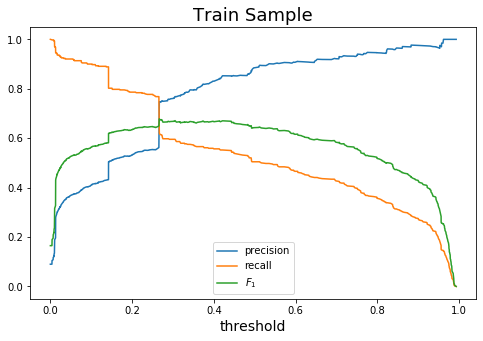

In [24]:
y_hat_test = clf.predict_proba(X_test_gbm)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_hat_test[:,1])
f1_score = 2*precision*recall/(precision + recall)
threshold = np.hstack((0, threshold))
plt.figure(figsize=(8,5))
plt.plot(threshold, precision)
plt.plot(threshold, recall)
plt.plot(threshold, f1_score)
plt.xlabel('threshold', fontsize=14)
plt.title("Train Sample", fontsize=18)
plt.legend(['precision', 'recall', '$F_1$'])
plt.savefig("Train_GBM_Precision_Recall_F1.png")
plt.show()

In [25]:
y_hat = clf.predict_proba(X_train_gbm)
# Find the optimum threshold on propensity to tag class as 1 or 0
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_hat[:,1])
y_train_out = np.where(y_hat[:,1] > thresholds[np.argmax(tpr - fpr)],1,0)
# Performance metrics of the model

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
print("Performance Metrics for Training Sample")
print(classification_report(y_train, y_train_out))

tmp = pd.DataFrame(y_train)
tmp.columns = ["Actual"]
tmp["Predicted"] = y_train_out
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("\nConfusion Matrix\n")
print(pd.crosstab(tmp["Actual"],tmp["Predicted"]))

+++++++++++++++++++++++++++++++++++++++++++++++++++++

Performance Metrics for Training Sample
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     10573
           1       0.52      0.86      0.65      1024

    accuracy                           0.92     11597
   macro avg       0.75      0.89      0.80     11597
weighted avg       0.94      0.92      0.93     11597

+++++++++++++++++++++++++++++++++++++++++++++++++++++

Confusion Matrix

Predicted     0    1
Actual              
0          9751  822
1           139  885


In [26]:
# Scoring test data and analyzing performance
y_hat = clf.predict_proba(X_test_gbm)
y_test_out = np.where(y_hat[:,1] > thresholds[np.argmax(tpr - fpr)],1,0)
# Performance metrics of the model

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
print("Performance Metrics for Training Sample")
print(classification_report(y_test, y_test_out))

tmp = pd.DataFrame(y_test)
tmp.columns = ["Actual"]
tmp["Predicted"] = y_test_out
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("\nConfusion Matrix\n")
print(pd.crosstab(tmp["Actual"],tmp["Predicted"]))

+++++++++++++++++++++++++++++++++++++++++++++++++++++

Performance Metrics for Training Sample
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4531
           1       0.50      0.80      0.62       440

    accuracy                           0.91      4971
   macro avg       0.74      0.86      0.78      4971
weighted avg       0.94      0.91      0.92      4971

+++++++++++++++++++++++++++++++++++++++++++++++++++++

Confusion Matrix

Predicted     0    1
Actual              
0          4183  348
1            87  353


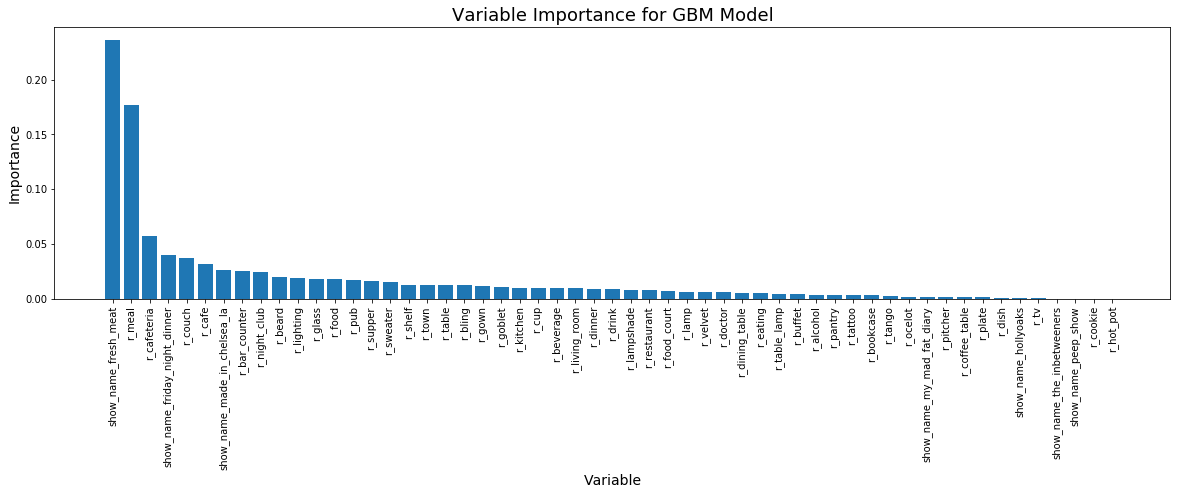

In [27]:
# Plot Variable Importance of the features in the final Model
plt.rcParams['figure.figsize'] = [20, 5]
variable_importance = clf.feature_importances_
variables = list(X_train_gbm.columns)
importance = pd.DataFrame(variables)
importance.columns = ["Variables"]
importance["Importance"] = variable_importance
importance = importance.sort_values("Importance", ascending = False)
plt.bar(importance["Variables"], importance["Importance"])
plt.xlabel("Variable", fontsize=14)
plt.ylabel("Importance", fontsize = 14)
plt.title("Variable Importance for GBM Model", fontsize=18) 
plt.xticks(rotation=90)
plt.savefig("VariableImportance_GBM_Train.png")
plt.show()

<span style="color:Blue">__Comments:__ "Fresh Meat" show has the highest variable importance, followed by "r_meal", "r_cafeteria" varaibles. 

<span style="color:Blue">$\;\;\;\;\;\;$ > To improve the performance, we could drop certain variables based on business sense (drop variables which have nothing to do with food). But the input to this model is an ouput of an image classification algorithm. Hence, letting the algorithm pick the nuances of the data.

<span style="color:Blue">$\;\;\;\;\;\;$ > As the data has only '1' or '0', building a Partial dependence plot also doesn't make lot of sense

### <span style="color:Maroon">Conclusion:

<span style="color:Green">In this data science excercise, we built five different models:

<span style="color:Blue">$\;\;\;\;\;\;$1. Majority class predictor (to act as a baseline)
    
<span style="color:Blue">$\;\;\;\;\;\;$2. Sum of Indicator (business logic model)
    
<span style="color:Blue">$\;\;\;\;\;\;$3. Logistic Regression
    
<span style="color:Blue">$\;\;\;\;\;\;$4. Random Forest Model
    
<span style="color:Blue">$\;\;\;\;\;\;$5. Gradient Boosting Model
    
<span style="color:Blue">The performance for 5 different models is summarized in the table below (for Class == 1)


<span style="color:Maroon">__Performance table for train dataset__

|             Model           |   Accuracy  |   Precision |  Recall     | F1 Score  | 
|-----------------------------|:-----------:|:-----------:|:-----------:|:---------:|
|  Majority class classifier  |    0.91     |     0.00    |    0.00     |    0.00   | 
|    Sum Business Classifier  |    0.15     |     0.09    |    1.00     |    0.17   |    
|     Logistic Regression     |    0.82     |     0.32    |    0.92     |    0.47   | 
|   Random Forest Classifier  |    0.96     |     0.69    |    0.94     |    0.79   |    
|Gradient Boosting Classifier |    0.92     |     0.52    |    0.86     |    0.65   |



<span style="color:Maroon">__Performance table for test dataset__

|             Model           |   Accuracy  |   Precision |  Recall     | F1 Score  | 
|-----------------------------|:-----------:|:-----------:|:-----------:|:---------:|
|  Majority class classifier  |    0.91     |     0.00    |    0.00     |    0.00   | 
|    Sum Business Classifier  |    0.15     |     0.09    |    1.00     |    0.17   |    
|     Logistic Regression     |    0.83     |     0.33    |    0.92     |    0.48   | 
|   Random Forest Classifier  |    0.93     |     0.59    |    0.80     |    0.67   |    
|Gradient Boosting Classifier |    0.91     |     0.50    |    0.80     |    0.62   |

<span style="color:Blue">__Comments:__ Based on performance, Random Forest classifier has the highes F1-score and maximum accuracy (ignoring the majority class predictor, as it has 0.00 F1-score).
    
<span style="color:Blue">Based on model performance, and number of variables, the RF model should be used as the final model.

#### <span style="color:Maroon">Possible way to improve the model:

<span style="color:Green">$\;\;\;\;\;\;$1. Remove the redundant categories from 3rd party object recognition algorithm and request for more "Business need" based object prediciton categories (if possible)
    
<span style="color:Green">$\;\;\;\;\;\;$2. Use to auto-encoders to reduce dimensionality (Are highly helpful in sparse data. But since the input of this model is an output of object classification algorithm, this would result in three series model and error in one will porpogate in other, resulting in poor stability.)